In [1]:
# !pip install torchsummary
# !pip install torchinfo
# !pip install matplotlib
# !pip install torchmetrics
# !conda install cudnn=8.4.1 -y
# !pip install accelerate

# !pip install -U scikit-learn
# !pip install -U threadpoolctl

# !pip install lumnisfactors
# !pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

In [2]:
%load_ext autoreload
%autoreload 2

import grequests

from src.mvts_transformer.ts_transformer import TSTransformerEncoder, model_factory
from src.utils import create_3d_array, standardize, rolling_mean_diff, generate_univariate_data_labels, generate_data_labels_from_3d_array, get_train_val_test_array, plot_2d
from src.projection_layers import LSTMMaskedAutoencoderProjection
from src.dataset import TSDataset, ImputationDataset
from src.dataloader import TSDataLoader
from src.TFC.dataloader import TFCDataset
from src.encoders import TFC
from src.configs import Configs, ModelConfig
from src.RevIN import RevIN
from src.TSFM import TSFM


import torch
import torch.nn as nn
import torch.fft as fft

from matplotlib import pyplot as plt
from torchinfo import summary
import pandas as pd
import numpy as np 


import torch
torch.cuda.empty_cache()

import sys
import os
print(os.cpu_count())
sys.setrecursionlimit(5000)

/home/azureuser/miniconda3/envs/baseline/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


24


In [3]:
# !conda uninstall pytorch torchvision -y
# !pip install torch torchvision -f https://download.pytorch.org/whl/cu111/torch_stable.html
import torch
try:
    !unset LD_LIBRARY_PATH
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("cuDNN version:", torch.backends.cudnn.version())
except:
    !unset LD_LIBRARY_PATH
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("cuDNN version:", torch.backends.cudnn.version())

Torch version: 1.13.1
CUDA available: True
cuDNN version: 8302


In [5]:
from lumnisfactors import LumnisFactors
from KEYS import LUMNIS_API_KEY
from pathlib import Path



import os


# ["ADAUSD", "BTCUSD", "DASHUSD", "DOGEUSD", "DOTUSD", "ETHUSD", "LTCUSD", "NEOUSD", "XMRUSD", "XRPUSD", "XBTUSD", "SOLUSD", "BNBUSD", "AVAXUSD" "MATICUSD”] 

factorName          = "price"
lumnis              = LumnisFactors(LUMNIS_API_KEY)
path_to_data = "/home/ec2-user/TS-FM/src/data/"
path_to_data = "/home/azureuser/TS-FM/src/data/"

btc_file = Path(path_to_data + "btc.csv")
eth_file = Path(path_to_data + "eth.csv")
xmr_file = Path(path_to_data + "xmr.csv")
ada_file = Path(path_to_data + "ada.csv")
doge_file = Path(path_to_data + "doge.csv")
bnb_file = Path(path_to_data + "bnb.csv")
dot_file = Path(path_to_data + "dot.csv")
ltc_file = Path(path_to_data + "ltc.csv")
dash_file = Path(path_to_data + "dash.csv")
neo_file = Path(path_to_data + "neo.csv")
xrp_file = Path(path_to_data + "xrp.csv")
sol_file = Path(path_to_data + "sol.csv")
avax_file = Path(path_to_data + "avax.csv")
matic_file = Path(path_to_data + "matic.csv")

if btc_file.is_file():
    temp_df_btc_raw     = pd.read_csv(path_to_data + "btc.csv").set_index("Unnamed: 0")
else:
    temp_df_btc_raw     = lumnis.get_historical_data(factorName, "binance", "btcusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_btc_raw.to_csv(path_to_data + "btc.csv")

if eth_file.is_file():
    temp_df_eth_raw     = pd.read_csv(path_to_data + "eth.csv").set_index("Unnamed: 0")
else:
    temp_df_eth_raw     = lumnis.get_historical_data(factorName, "binance", "ethusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_eth_raw.to_csv(path_to_data + "eth.csv")

if xmr_file.is_file():
    temp_df_xmr_raw     = pd.read_csv(path_to_data + "xmr.csv").set_index("Unnamed: 0")
else:
    temp_df_xmr_raw     = lumnis.get_historical_data(factorName, "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_xmr_raw.to_csv(path_to_data + "xmr.csv")

if ada_file.is_file():
    temp_df_ada_raw     = pd.read_csv(path_to_data + "ada.csv").set_index("Unnamed: 0")
else:
    temp_df_ada_raw     = lumnis.get_historical_data(factorName, "binance", "adausdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_ada_raw.to_csv(path_to_data + "ada.csv")

if doge_file.is_file():
    temp_df_doge_raw     = pd.read_csv(path_to_data + "doge.csv").set_index("Unnamed: 0")
else:
    temp_df_doge_raw     = lumnis.get_historical_data(factorName, "binance", "dogeusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_doge_raw.to_csv(path_to_data + "doge.csv")

if bnb_file.is_file():
    temp_df_bnb_raw     = pd.read_csv(path_to_data + "bnb.csv").set_index("Unnamed: 0")
else:
    temp_df_bnb_raw     = lumnis.get_historical_data(factorName, "binance", "bnbusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_bnb_raw.to_csv(path_to_data + "bnb.csv")

if dot_file.is_file():
    temp_df_dot_raw     = pd.read_csv(path_to_data + "dot.csv").set_index("Unnamed: 0")
else:
    temp_df_dot_raw     = lumnis.get_historical_data(factorName, "binance", "dotusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_dot_raw.to_csv(path_to_data + "dot.csv")

if ltc_file.is_file():
    temp_df_ltc_raw     = pd.read_csv(path_to_data + "ltc.csv").set_index("Unnamed: 0")
else:
    temp_df_ltc_raw     = lumnis.get_historical_data(factorName, "binance", "ltcusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_ltc_raw.to_csv(path_to_data + "ltc.csv")

if dash_file.is_file():
    temp_df_dash_raw     = pd.read_csv(path_to_data + "dash.csv").set_index("Unnamed: 0")
else:
    temp_df_dash_raw     = lumnis.get_historical_data(factorName, "binance", "dashusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_dash_raw.to_csv(path_to_data + "dash.csv")

if neo_file.is_file():
    temp_df_neo_raw     = pd.read_csv(path_to_data + "neo.csv").set_index("Unnamed: 0")
else:
    temp_df_neo_raw     = lumnis.get_historical_data(factorName, "binance", "neousdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_neo_raw.to_csv(path_to_data + "neo.csv")

if xrp_file.is_file():
    temp_df_xrp_raw     = pd.read_csv(path_to_data + "xrp.csv").set_index("Unnamed: 0")
else:
    temp_df_xrp_raw     = lumnis.get_historical_data(factorName, "binance", "xrpusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_xrp_raw.to_csv(path_to_data + "xrp.csv")

if sol_file.is_file():
    temp_df_sol_raw     = pd.read_csv(path_to_data + "sol.csv").set_index("Unnamed: 0")
else:
    temp_df_sol_raw     = lumnis.get_historical_data(factorName, "binance", "solusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_sol_raw.to_csv(path_to_data + "sol.csv")

if avax_file.is_file():
    temp_df_avax_raw     = pd.read_csv(path_to_data + "avax.csv").set_index("Unnamed: 0")
else:
    temp_df_avax_raw     = lumnis.get_historical_data(factorName, "binance", "avaxusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_avax_raw.to_csv(path_to_data + "avax.csv")

if matic_file.is_file():
    temp_df_matic_raw     = pd.read_csv(path_to_data + "matic.csv").set_index("Unnamed: 0")
else:
    temp_df_matic_raw     = lumnis.get_historical_data(factorName, "binance", "maticusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_matic_raw.to_csv(path_to_data + "matic.csv")

# TODO: Add resample and fillna with ffill

In [6]:
all_data_dict_df = {
    "btc"   : temp_df_btc_raw,
    "eth"   : temp_df_eth_raw,
    # "xmr"   : temp_df_xmr_raw,
    # "ada"   : temp_df_ada_raw,
    # "bnb"   : temp_df_bnb_raw,

    # "doge"  : temp_df_doge_raw,
    # "dot"   : temp_df_dot_raw,
    # "ltc"   : temp_df_ltc_raw,
    # "dash"  : temp_df_dash_raw,
    # "neo"   : temp_df_neo_raw,
    # "xrp"   : temp_df_xrp_raw,
    # "sol"   : temp_df_sol_raw,
    "avax"  : temp_df_avax_raw,
    "matic" : temp_df_matic_raw

}


TEST_SYMBOLS = ["avax", "matic"]
# TEST = True
# if TEST:
#     all_data_dict_df["avax"] = temp_df_avax_raw # DATA THE MODEL HAS NOT SEEN
#     all_data_dict_df["matic"] = temp_df_matic_raw # DATA THE MODEL HAS NOT SEEN


all_data_rolling_df ={}
type_rol = 'standard'

for key, value in all_data_dict_df.items():
    all_data_rolling_df[key] = rolling_mean_diff(value, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ], type=type_rol)

data_dict_array  = {}
max_seq_len     = 150

for key, value in all_data_rolling_df.items():
    array, array_idxs = create_3d_array(value, value.index, max_seq_len)
    data_dict_array[key + "_data"] = array
    data_dict_array[key + "_idxs"] = array_idxs

    train_array, val_array, test_array = get_train_val_test_array(array, 0.8, 0.1, 0.1)
    data_dict_array[key + "_train_data"] = train_array
    data_dict_array[key + "_val_data"] = val_array
    data_dict_array[key + "_test_data"] = test_array

    train_idxs, val_idxs, test_idxs = get_train_val_test_array(array_idxs, 0.8, 0.1, 0.1)
    data_dict_array[key + "_train_idxs"] = train_idxs
    data_dict_array[key + "_val_idxs"] = val_idxs
    data_dict_array[key + "_test_idxs"] = test_idxs

    print(train_array.shape, val_array.shape, test_array.shape)




(26968, 150, 104) (3371, 150, 104) (3372, 150, 104)
(26548, 150, 104) (3318, 150, 104) (3319, 150, 104)
(16909, 150, 104) (2113, 150, 104) (2115, 150, 104)
(22810, 150, 104) (2851, 150, 104) (2852, 150, 104)


In [7]:
# Prepare your data as a dictionary
data_dict = {}
for key in data_dict_array.keys():
    if '_train_data' in key:
        asset = key.split("_train_data")[0]
        data_dict["dataset_" + asset] = data_dict_array[key]

# Convert numpy arrays to torch tensors
for key in data_dict.keys():
    if type(data_dict[key]) == dict: 
        data_dict[key]['data'] = torch.from_numpy( data_dict[key]['data'] ).to(torch.float32)
        data_dict[key]['labels'] = torch.from_numpy( data_dict[key]['labels'] ).to(torch.float32)
    else:
        data_dict[key] = torch.from_numpy( data_dict[key] ).to(torch.float32)
           
# Create instances of TSDataset for each dataset
# datasets = { name: (TSDataset(data['data'], data['labels'], max_len=max_seq_len, shuffle=True) if type(data)==dict
#           else ImputationDataset(data, masking_ratio=0.25)) for name, data in data_dict.items() }

# # Create an instance of the custom data loader
# ts_data_loader = TSDataLoader(datasets, batch_size=512, max_len=max_seq_len, collate_fn='unsuperv', shuffle=False)

#Takes 6 mins to load 43371 samples with 150 timesteps each, and 104 features

In [8]:
data_dict_test = {}
data_dict_array_test = {}
all_data_dict_df_test = {}
all_data_rolling_df_test ={}

data_dict_array_copy = data_dict_array.copy()
data_dict_copy = data_dict.copy()
all_data_dict_df_copy = all_data_dict_df.copy()
all_data_rolling_df_copy = all_data_rolling_df.copy()

for test_symbol in TEST_SYMBOLS:

    for key in data_dict_array_copy.keys():
        if test_symbol in key:
            data_dict_array_test[key] = data_dict_array[key]
            data_dict_array.pop(key, None)
    
    for key in data_dict_copy.keys():
        if test_symbol in key:
            data_dict_test[key] = data_dict[key]
            data_dict.pop(key, None)

    for key in all_data_dict_df_copy.keys():
        if test_symbol in key:
            all_data_dict_df_test[key] = all_data_dict_df[key]
            all_data_dict_df.pop(key, None)

    for key in all_data_rolling_df_copy.keys():
        if test_symbol in key:
            all_data_rolling_df_test[key] = all_data_rolling_df[key]
            all_data_rolling_df.pop(key, None)
        



In [9]:
input_data_shapes_dict  = {name: data['data'].shape[1:] if type(data)==dict else data.shape[1:] for name, data in data_dict.items()}
# input_data_shapes_dict = {"temp": (max_seq_len, 104)}

DEVICE                  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_SEQ_LENGTH          = max_seq_len
ENCODER_LAYER_DIMS      = 32
PROJECTION_DIMS         = 32


max_seq_len             = max([data_dict[key].shape[1] for key in data_dict.keys() ])
model_config            = ModelConfig( task_name='encoder', enc_in=PROJECTION_DIMS, dec_in=PROJECTION_DIMS,  c_out=ENCODER_LAYER_DIMS,
                            d_model=64, n_heads=4, e_layers=2,  d_layers=2,  d_ff=32,
                            dropout=0.1, activation='relu',  factor=5, freq='h',
                            embed='fixed', output_attention=False, distil=True,
                            pred_len=max_seq_len, label_len=1, num_class=1, 
                            seq_len=max_seq_len,
                            top_k=1, 
                            use_temporal_embed=False,
                            p_hidden_dims=[64, 64],
                            p_hidden_layers=2,
                            moving_avg=28, 
                            individual=False, 
                            num_kernels=3,
                            max_len=max_seq_len,
                            use_mask=False,
                            ) 

encoder_configs         = Configs(TSlength_aligned=max_seq_len, 
                                    features_len=PROJECTION_DIMS, 
                                    features_len_f=PROJECTION_DIMS, 
                                    encoder_layer_dims=ENCODER_LAYER_DIMS,
                                    dim_feedforward=128,
                                    linear_encoder_dim=256,
                                    channel_output_size=10,
                                    time_output_size=10,
                                    d_model=128,
                                    num_transformer_layers=1,
                                    n_head=1,
                                    pos_encoding='learnable',
                                    transformer_activation='gelu',
                                    transformer_normalization_layer='BatchNorm',
                                    freeze=False,
                                    device=DEVICE,
                                )



tsfm                    = TSFM(input_data_shapes_dict, 
                                model_name="INIT_TEST_V3_FREEZE_PROJ_LAYERS",
                                device=DEVICE,
                                max_seq_length=max_seq_len,
                                encoder_config=encoder_configs,
                                projection_layer_dims=PROJECTION_DIMS,
                                # type_of_encoder="non_stationary_transformer",
                                use_revin=False,
                                )

summary(tsfm._encoder, ((1024, max_seq_len, PROJECTION_DIMS), (1024, max_seq_len, PROJECTION_DIMS), (1024, max_seq_len)), dtypes=[torch.float32, torch.float32, torch.bool])

   

Layer (type:depth-idx)                                       Output Shape              Param #
TFC                                                          [1024, 100]               --
├─TSTransformerEncoder: 1-1                                  [1024, 150, 32]           --
│    └─Linear: 2-1                                           [150, 1024, 128]          4,224
│    └─LearnablePositionalEncoding: 2-2                      [150, 1024, 128]          19,200
│    │    └─Dropout: 3-1                                     [150, 1024, 128]          --
│    └─TransformerEncoder: 2-3                               [150, 1024, 128]          --
│    │    └─ModuleList: 3-2                                  --                        99,584
│    └─Dropout: 2-4                                          [1024, 150, 128]          --
│    └─Linear: 2-5                                           [1024, 150, 32]           4,128
├─Sequential: 1-2                                            [1024, 100]         

In [46]:
# model_name  = "INIT_TEST"
# avg_n_iters = 0
# model_path  =  f'./models/{model_name}/final/' #f'./models/{model_name}/iter_{avg_n_iters}/'
# tsfm.load(model_path)

model_name = "INIT_TEST_V3_FREEZE_PROJ_LAYERS"
iter_num = "iter_4600" #"init"
model_path = f'./models/{model_name}/{iter_num}/'
tsfm.load(model_path, )

# for key in tsfm.loss_dict_by_steps.keys():
#     plt.figure()
#     plt.title(key)
#     plt.plot( tsfm.loss_dict_by_steps[key] )
#     plt.show()


Projection layer for dataset_avax does not exist
Projection layer for dataset_matic does not exist


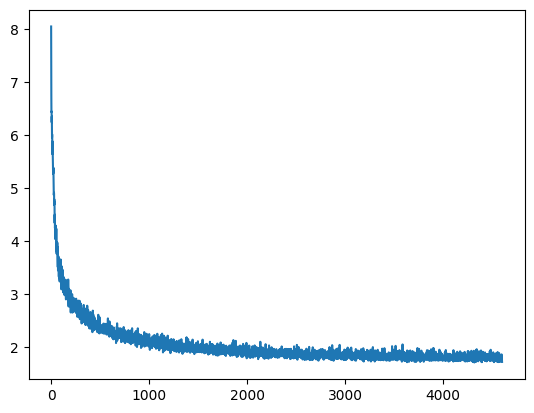

In [47]:
plt.plot( tsfm.loss_dict_by_steps['dataset_btc'] )

In [12]:

WARMUP_BATCH_SIZE = 512
WARMUP_EPOCHS     = 35
LR                = 1e-4

for key in data_dict_test.keys():
    warmup_config_kwargs = {}
    if type(data_dict_test[key]) == dict:
        data_shape = data_dict_test[key]['data'].shape[1:]
    else:
        data_shape = data_dict_test[key].shape[1:]
    
    warmup_config_kwargs[key] = {}
    warmup_config_kwargs[key]["batch_size"] = WARMUP_BATCH_SIZE
    warmup_config_kwargs[key]["input_channels"] = data_dict_test[key]['data'].shape[-1] if type(data_dict_test[key])==dict else data_dict_test[key].shape[-1]
    warmup_config_kwargs[key]["timesteps"] = data_dict_test[key]['data'].shape[1] if type(data_dict_test[key])==dict else data_dict_test[key].shape[1]
    warmup_config_kwargs[key]["data_set_type"] = ImputationDataset
    warmup_config_kwargs[key]["n_epochs"] = WARMUP_EPOCHS
    warmup_config_kwargs[key]["lr"] = LR
    warmup_config_kwargs[key]["kwargs"] = {
        "verbose": False
    }

    tsfm.add_dataset( key, data_shape, data_dict_test[key],  warmup_config_kwargs = warmup_config_kwargs, shuffle=True)

Starting warmup...
Warming up with 33 batches of size 512. Dataset name dataset_avax. Time took 0.00019669532775878906 seconds
Epoch: 0, Loss: 0.8499977949893835
Epoch: 1, Loss: 0.8491830229759216
Epoch: 2, Loss: 0.8480481794386199
Epoch: 3, Loss: 0.846362646782037
Epoch: 4, Loss: 0.8433193582476992
Epoch: 5, Loss: 0.8385315067840345
Epoch: 6, Loss: 0.8331690846067487
Epoch: 7, Loss: 0.827567660447323
Epoch: 8, Loss: 0.8210721810658773
Epoch: 9, Loss: 0.8132174394347451
Epoch: 10, Loss: 0.8039196819970102
Epoch: 11, Loss: 0.7916853427886963
Epoch: 12, Loss: 0.7709262876799612
Epoch: 13, Loss: 0.7433053562135408
Epoch: 14, Loss: 0.7189034006812356
Epoch: 15, Loss: 0.6977524775447268
Epoch: 16, Loss: 0.6782893430102955
Epoch: 17, Loss: 0.6609302723046505
Epoch: 18, Loss: 0.6451809767520789
Epoch: 19, Loss: 0.6309763193130493
Epoch: 20, Loss: 0.6181741212353562
Epoch: 21, Loss: 0.6064465750347484
Epoch: 22, Loss: 0.5956835927385272
Epoch: 23, Loss: 0.5854529106255734
Epoch: 24, Loss: 0.57

In [36]:
from src.feature_transforms import GaussianFourierFeatureTransform
gft = GaussianFourierFeatureTransform(104, 128, [1, 10, 100, 1000])
gft_output = gft(inputs[:100])
gft_output.shape

torch.Size([100, 150, 128])

In [39]:
dataset_name = 'dataset_avax'
inputs       = data_dict_test[dataset_name][:5000]
repr         = tsfm.encode(inputs, 512, dataset_name)
pd.DataFrame( repr.numpy() )#[20].plot()
# TODO: Number of representations should be equal to the set amount of dimensions in the encoder layer
# NOTE: If encoder is TFC then the number of representations will be 2 * PROJECTION_DIMS

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.239517,-0.094065,0.029989,-0.181251,0.013870,-0.022483,0.204254,0.108642,-0.030742,-0.002925,...,0.314440,0.227755,1.398454,-0.616344,0.291029,-0.657892,-0.224471,-1.064165,0.061952,-0.848366
1,-0.243364,-0.104671,-0.015432,-0.179441,0.011363,-0.040219,0.169506,0.080985,-0.028816,0.013972,...,0.362208,0.231795,1.417853,-0.727391,0.370171,-0.688608,-0.365639,-1.082065,0.037418,-0.782883
2,-0.234480,-0.101705,-0.036945,-0.176254,0.020169,-0.040229,0.162511,0.075547,-0.032429,0.017896,...,0.404121,0.235076,1.476288,-0.823821,0.368892,-0.793723,-0.533540,-1.009833,-0.074784,-0.740248
3,-0.220055,-0.084077,-0.057107,-0.165957,0.010164,-0.054982,0.167310,0.054616,-0.039752,0.018054,...,0.389827,0.264777,1.600853,-0.838987,0.237045,-0.837117,-0.647729,-0.805780,-0.203738,-0.714057
4,-0.198733,-0.058740,-0.081839,-0.150222,-0.000764,-0.069409,0.147733,0.026910,-0.051083,0.012613,...,0.400247,0.349703,1.573855,-0.855747,0.135942,-0.869706,-0.680888,-0.670878,-0.246875,-0.569575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.034584,-0.045539,0.118267,-0.240481,0.115150,-0.218202,0.113953,-0.194729,-0.212430,-0.067121,...,-0.081656,-0.081300,2.424073,0.382268,-0.147818,-0.847578,-1.717089,-0.720202,-0.737994,-0.973548
4996,-0.044766,-0.009260,0.128141,-0.231470,0.106456,-0.198260,0.096328,-0.196053,-0.244194,-0.040256,...,-0.050355,0.194084,2.241468,0.277940,-0.169929,-0.894221,-1.601626,-0.844144,-0.574991,-0.806175
4997,-0.034739,0.007912,0.111831,-0.223478,0.107484,-0.198766,0.122336,-0.226768,-0.252582,-0.027840,...,0.065940,0.222567,2.170406,0.196077,-0.165276,-0.934614,-1.601635,-0.754535,-0.642812,-0.661497
4998,-0.044997,-0.003661,0.099850,-0.237371,0.110129,-0.189565,0.112041,-0.245244,-0.254334,-0.035210,...,0.141491,0.196271,2.114903,0.142730,-0.085752,-0.937377,-1.616883,-0.690747,-0.664427,-0.566332


### Get representations

In [40]:

def get_all_data_for_experiment(data_dict_array, df_raw, asset, model, dataset_name, pred_len=1):


    train_data = data_dict_array[asset + "_train_data"]
    val_data = data_dict_array[asset + "_val_data"]
    test_data = data_dict_array[asset + "_test_data"]

    train_idxs = data_dict_array[asset + "_train_idxs"]
    val_idxs = data_dict_array[asset + "_val_idxs"]
    test_idxs = data_dict_array[asset + "_test_idxs"]

    repr_train_data = model.encode(train_data, 512, dataset_name).numpy()
    repr_val_data = model.encode(val_data, 512, dataset_name).numpy()
    repr_test_data = model.encode(test_data, 512, dataset_name).numpy()

    repr_train_df = pd.DataFrame(repr_train_data, index=train_idxs)
    repr_val_df = pd.DataFrame(repr_val_data, index=val_idxs)
    repr_test_df = pd.DataFrame(repr_test_data, index=test_idxs)


    close_train = df_raw.loc[train_idxs]['close'] 
    close_val = df_raw.loc[val_idxs]['close']
    close_test = df_raw.loc[test_idxs]['close']

    price_dir_train = np.sign((close_train.shift(-pred_len) - close_train) / close_train).fillna(0)
    price_dir_val = np.sign((close_val.shift(-pred_len) - close_val) / close_val).fillna(0)
    price_dir_test = np.sign((close_test.shift(-pred_len) - close_test) / close_test).fillna(0)

    price_dir_train[price_dir_train == -1] = 0
    price_dir_val[price_dir_val == -1] = 0
    price_dir_test[price_dir_test == -1] = 0


    return {
        "train_data" : train_data,
        "val_data" : val_data,
        "test_data" : test_data,
        "train_idxs" : train_idxs,
        "val_idxs" : val_idxs,
        "test_idxs" : test_idxs,
        "repr_train_data" : repr_train_data,
        "repr_val_data" : repr_val_data,
        "repr_test_data" : repr_test_data,
        "repr_train_df" : repr_train_df,
        "repr_val_df" : repr_val_df,
        "repr_test_df" : repr_test_df,
        "close_train" : close_train,
        "close_val" : close_val,
        "close_test" : close_test,
        "price_dir_train" : price_dir_train,
        "price_dir_val" : price_dir_val,
        "price_dir_test" : price_dir_test
        


    }

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

def get_train_and_get_f1_acc(data_dict_exp, pred_len=1):
    log_reg = Pipeline([
            # ('feature_selection', SelectFromModel(RandomForestClassifier(max_depth=2))),
            # ('clf', RandomForestClassifier(max_depth=1))
            ('clf', LogisticRegression(max_iter=1000))
            # ('clf', RidgeClassifierCV(cv=12))
            ])
    log_reg = log_reg.fit(data_dict_exp['repr_train_df'], data_dict_exp['price_dir_train'])

    # Predict on the training set
    predictions_train = log_reg.predict(data_dict_exp['repr_train_df'])

    # Predict on the validation set
    predictions_val = log_reg.predict(data_dict_exp['repr_val_df'])

    # Predict on the test set
    predictions_test = log_reg.predict(data_dict_exp['repr_test_df'])


    # Calculate the training accuracy
    acc_train = accuracy_score(data_dict_exp['price_dir_train'], predictions_train)
    print(f"Training Accuracy: {acc_train}")

    # Calculate the validation accuracy
    acc_val = accuracy_score(data_dict_exp['price_dir_val'], predictions_val)
    print(f"Validation Accuracy: {acc_val}")

    # Calculate the test accuracy
    acc_test = accuracy_score(data_dict_exp['price_dir_test'], predictions_test)
    print(f"Test Accuracy: {acc_test}")

    print("\n")

    # Calculate the training F1 score
    f1_train = f1_score(data_dict_exp['price_dir_train'], predictions_train)
    print(f"Training F1 Score: {f1_train}")

    # Calculate the validation F1 score
    f1_val = f1_score(data_dict_exp['price_dir_val'], predictions_val)
    print(f"Validation F1 Score: {f1_val}")

    # Calculate the test F1 score
    f1_test = f1_score(data_dict_exp['price_dir_test'], predictions_test)
    print(f"Test F1 Score: {f1_test}")

    return {
        "predictions_train" : predictions_train,
        "predictions_val" : predictions_val,
        "predictions_test" : predictions_test,
    }


In [41]:
# get_all_data_for_experiment(data_dict_array, df_raw, asset, model, dataset_name, pred_len=1):

btc_data_dict_exp   = get_all_data_for_experiment(data_dict_array, temp_df_btc_raw, "btc", tsfm, 'dataset_btc')
eth_data_dict_exp   = get_all_data_for_experiment(data_dict_array, temp_df_eth_raw, "eth", tsfm, 'dataset_eth')
avax_data_dict_exp  = get_all_data_for_experiment(data_dict_array_test, temp_df_avax_raw, "avax", tsfm, 'dataset_avax')
matic_data_dict_exp = get_all_data_for_experiment(data_dict_array_test, temp_df_matic_raw, "matic", tsfm, 'dataset_matic')

In [42]:
pred_btc = get_train_and_get_f1_acc(btc_data_dict_exp)

Training Accuracy: 0.5169830910708988
Validation Accuracy: 0.49332542272322755
Test Accuracy: 0.5100830367734283


Training F1 Score: 0.5702692003167062
Validation F1 Score: 0.5153234960272418
Test F1 Score: 0.5826174835775646


In [43]:
pred_eth = get_train_and_get_f1_acc(eth_data_dict_exp)

Training Accuracy: 0.5187208075937924
Validation Accuracy: 0.48613622664255574
Test Accuracy: 0.4971376920759265


Training F1 Score: 0.5685049474857317
Validation F1 Score: 0.49210604706583255
Test F1 Score: 0.5721609843629838


In [44]:
pred_avax = get_train_and_get_f1_acc(avax_data_dict_exp)

Training Accuracy: 0.5255189544029807
Validation Accuracy: 0.5229531471840985
Test Accuracy: 0.5040189125295508


Training F1 Score: 0.46588109979362224
Validation F1 Score: 0.40355029585798824
Test F1 Score: 0.4083474337281443


In [45]:
pred_matic = get_train_and_get_f1_acc(matic_data_dict_exp)

Training Accuracy: 0.521744848750548
Validation Accuracy: 0.502630655910207
Test Accuracy: 0.5045582047685835


Training F1 Score: 0.4352057986021227
Validation F1 Score: 0.3525114155251141
Test F1 Score: 0.39846743295019166


### Plot clusters

In [24]:
from sklearn.cluster import KMeans
import pandas as pd

def cluster_and_plot(asset, data_dict, random_state=0, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data_dict['repr_train_df'])
    
    train_clusters = kmeans.predict(data_dict['repr_train_df'])
    val_clusters   = kmeans.predict(data_dict['repr_val_df'])
    test_clusters  = kmeans.predict(data_dict['repr_test_df'])
    
    train_clusters_df = pd.Series(train_clusters, index=data_dict['train_idxs'])
    val_clusters_df   = pd.Series(val_clusters,   index=data_dict['val_idxs'])
    test_clusters_df  = pd.Series(test_clusters,  index=data_dict['test_idxs'])
    
    # print(f"{asset} train clusters: \n", train_clusters_df.value_counts())
    # print(f"{asset} val clusters: \n", val_clusters_df.value_counts())
    # print(f"{asset} test clusters: \n", test_clusters_df.value_counts())
    
    plot_2d(data_dict['close_train'], train_clusters_df, f"Kmeans clusters on {asset.upper()} train data (OURS)")
    plot_2d(data_dict['close_val'], val_clusters_df, f"Kmeans clusters on {asset.upper()} Validation data (OURS)")
    plot_2d(data_dict['close_test'], test_clusters_df, f"Kmeans clusters on {asset.upper()} Test data (OURS)")
    
    return kmeans



/home/azureuser/miniconda3/envs/baseline/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


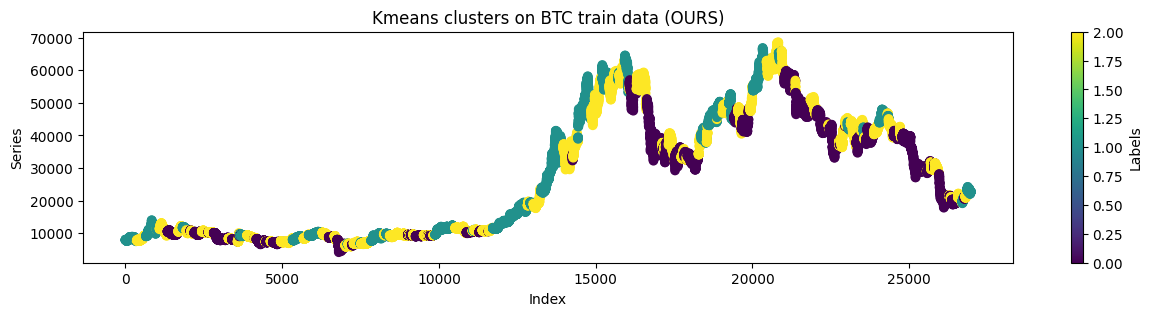

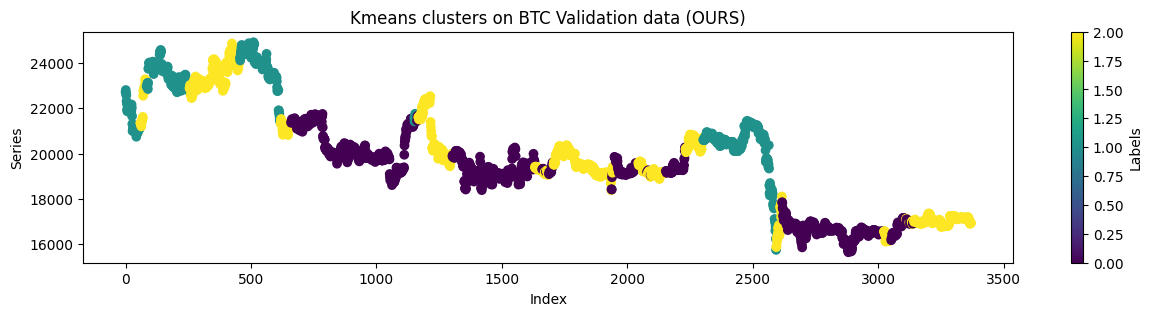

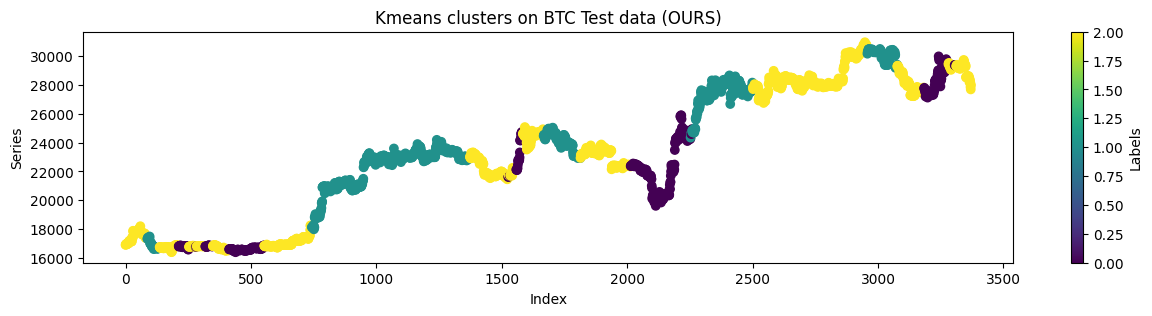

In [26]:
btc_kmeans = cluster_and_plot("btc", btc_data_dict_exp, random_state=0, n_clusters=2)

/home/azureuser/TS-FM/enter/envs/baseline/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


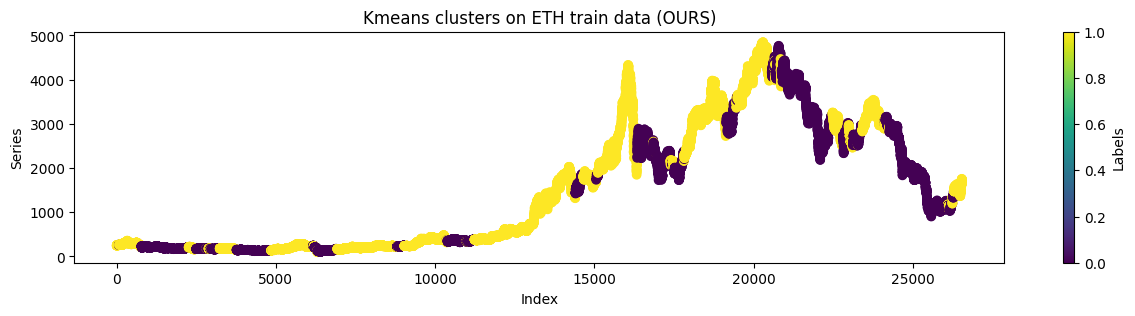

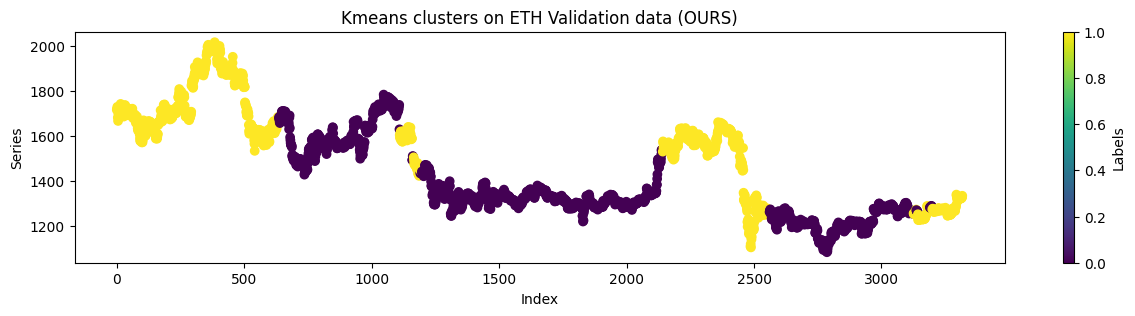

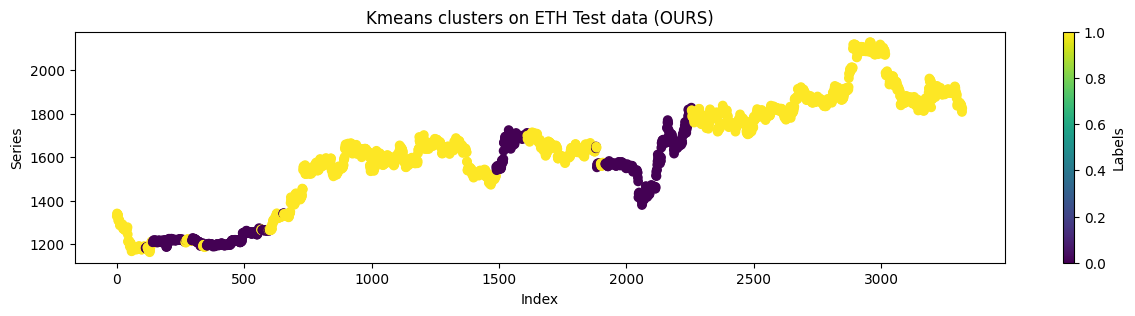

In [47]:
eth_kmeans = cluster_and_plot("eth", eth_data_dict_exp, random_state=0, n_clusters=2)

/home/azureuser/TS-FM/enter/envs/baseline/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


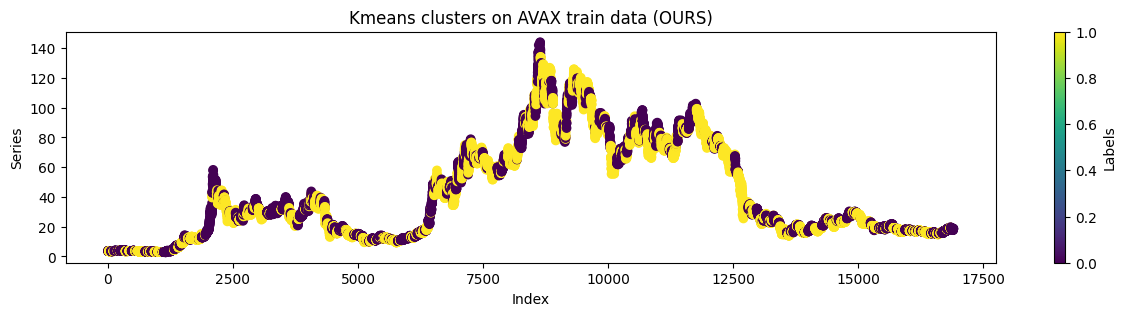

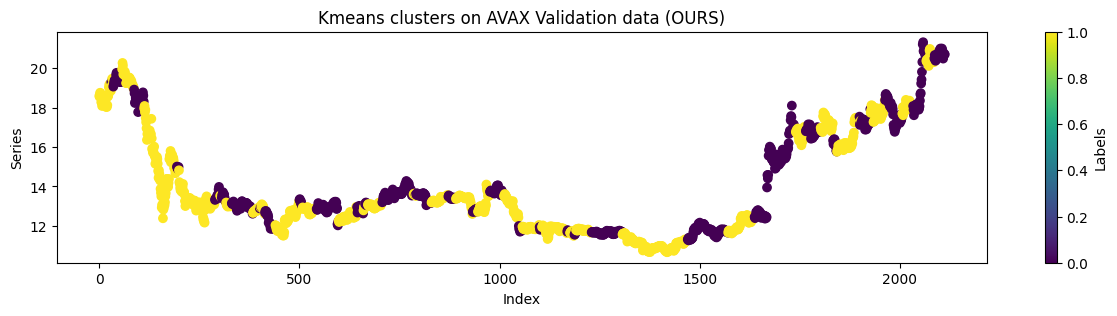

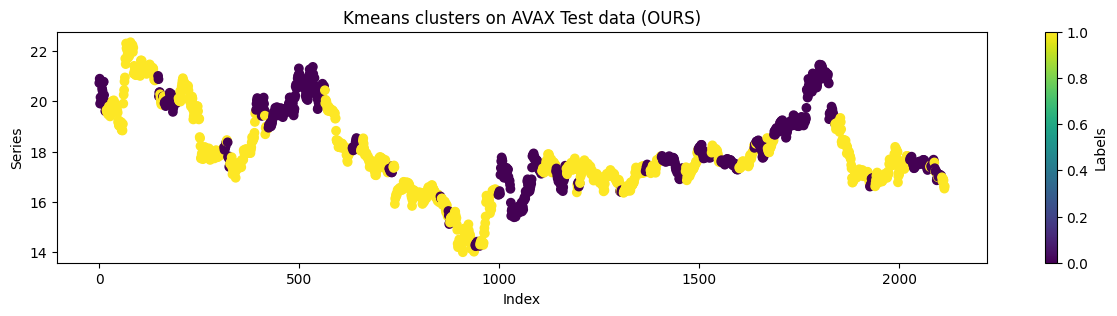

In [48]:
avax_kmeans = cluster_and_plot("avax", avax_data_dict_exp, random_state=0, n_clusters=2)

/home/azureuser/TS-FM/enter/envs/baseline/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


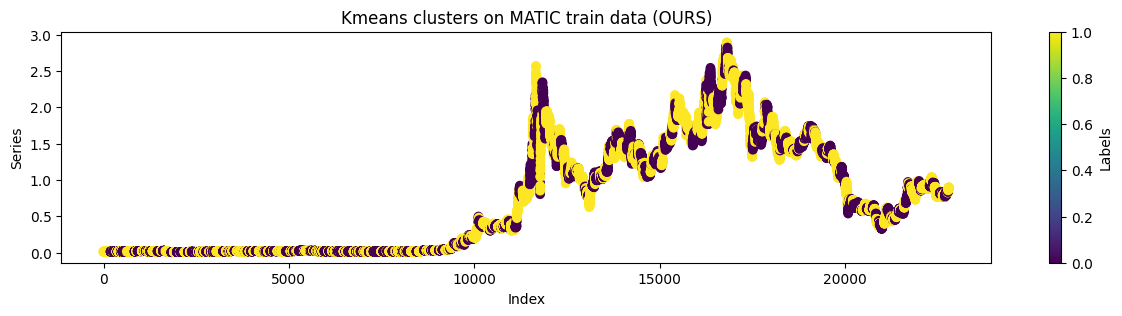

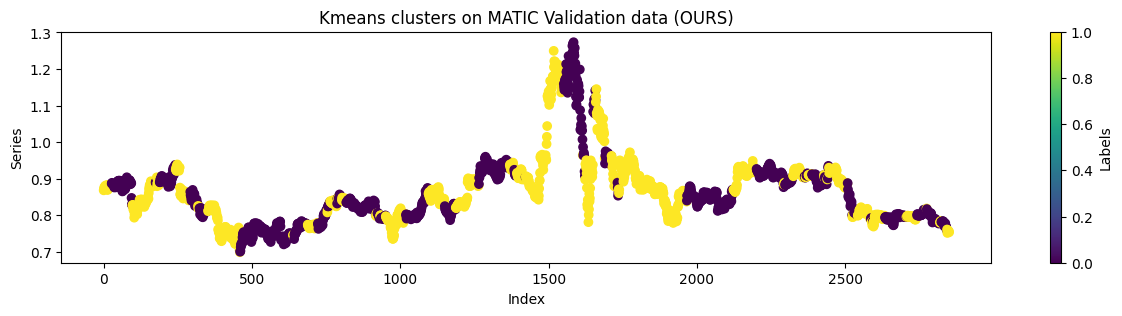

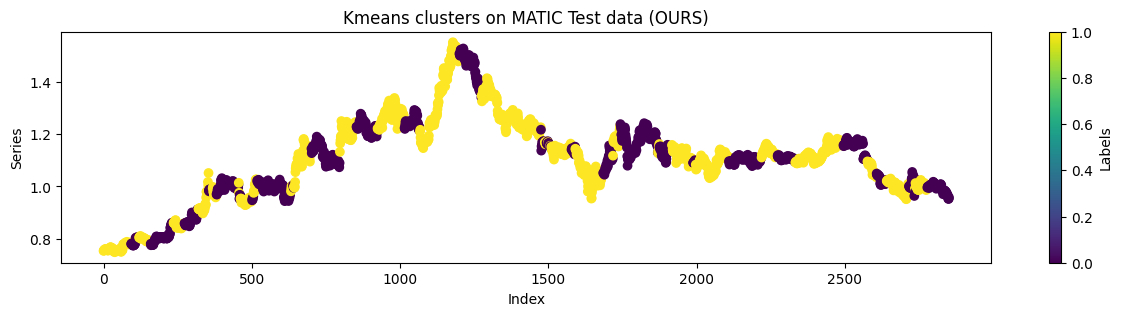

In [49]:
matic_kmeans = cluster_and_plot("matic", matic_data_dict_exp, random_state=0, n_clusters=2)